Remarks on ODEBench data:
-  63 time series from different ODEs -> id
- dimensions: 
    - ids 1-23: 1D
    - ids 24-51: 2D
    - ids 52-61: 3D (most complex systems)
    - ids 62-63: 4D
- sampled with 
    - different noise levels (determined by `sigma`)
    - different subsampling parameter (determined by `rho`)
    - each time series was sampled 20 times with each hyperparameter combination


- `.../predictions.pt` contain output of the model and the corresponding ground truth
    - keys: 
        - `sample_paths_target`
        - `sample_path_prediction`
        - `times_target`
        - `times_prediction`
        - `observation_times`
        - `observation_values`
        - `observation_mask`
        - `ids`


In [16]:
import torch
import matplotlib.pyplot as plt
from fim.utils.metrics import compute_metrics
import json

# Plot ODEBench performance

In [17]:
# set hyperparameters
rho = "0_5"
sigma = "0.05"

# load data
data_folder = "reports/FIMWindowed/ODEBench/16windows_25%overlap/MinMax/"
data_dim_1 = torch.load(data_folder + "dim1" + "_sigma" + sigma + "_rho" + rho+"/predictions.pt")
data_dim_2 = torch.load(data_folder + "dim2" + "_sigma" + sigma + "_rho" + rho+"/predictions.pt")
data_dim_3 = torch.load(data_folder + "dim3" + "_sigma" + sigma + "_rho" + rho+"/predictions.pt")
data_dim_4 = torch.load(data_folder + "dim4" + "_sigma" + sigma + "_rho" + rho+"/predictions.pt")


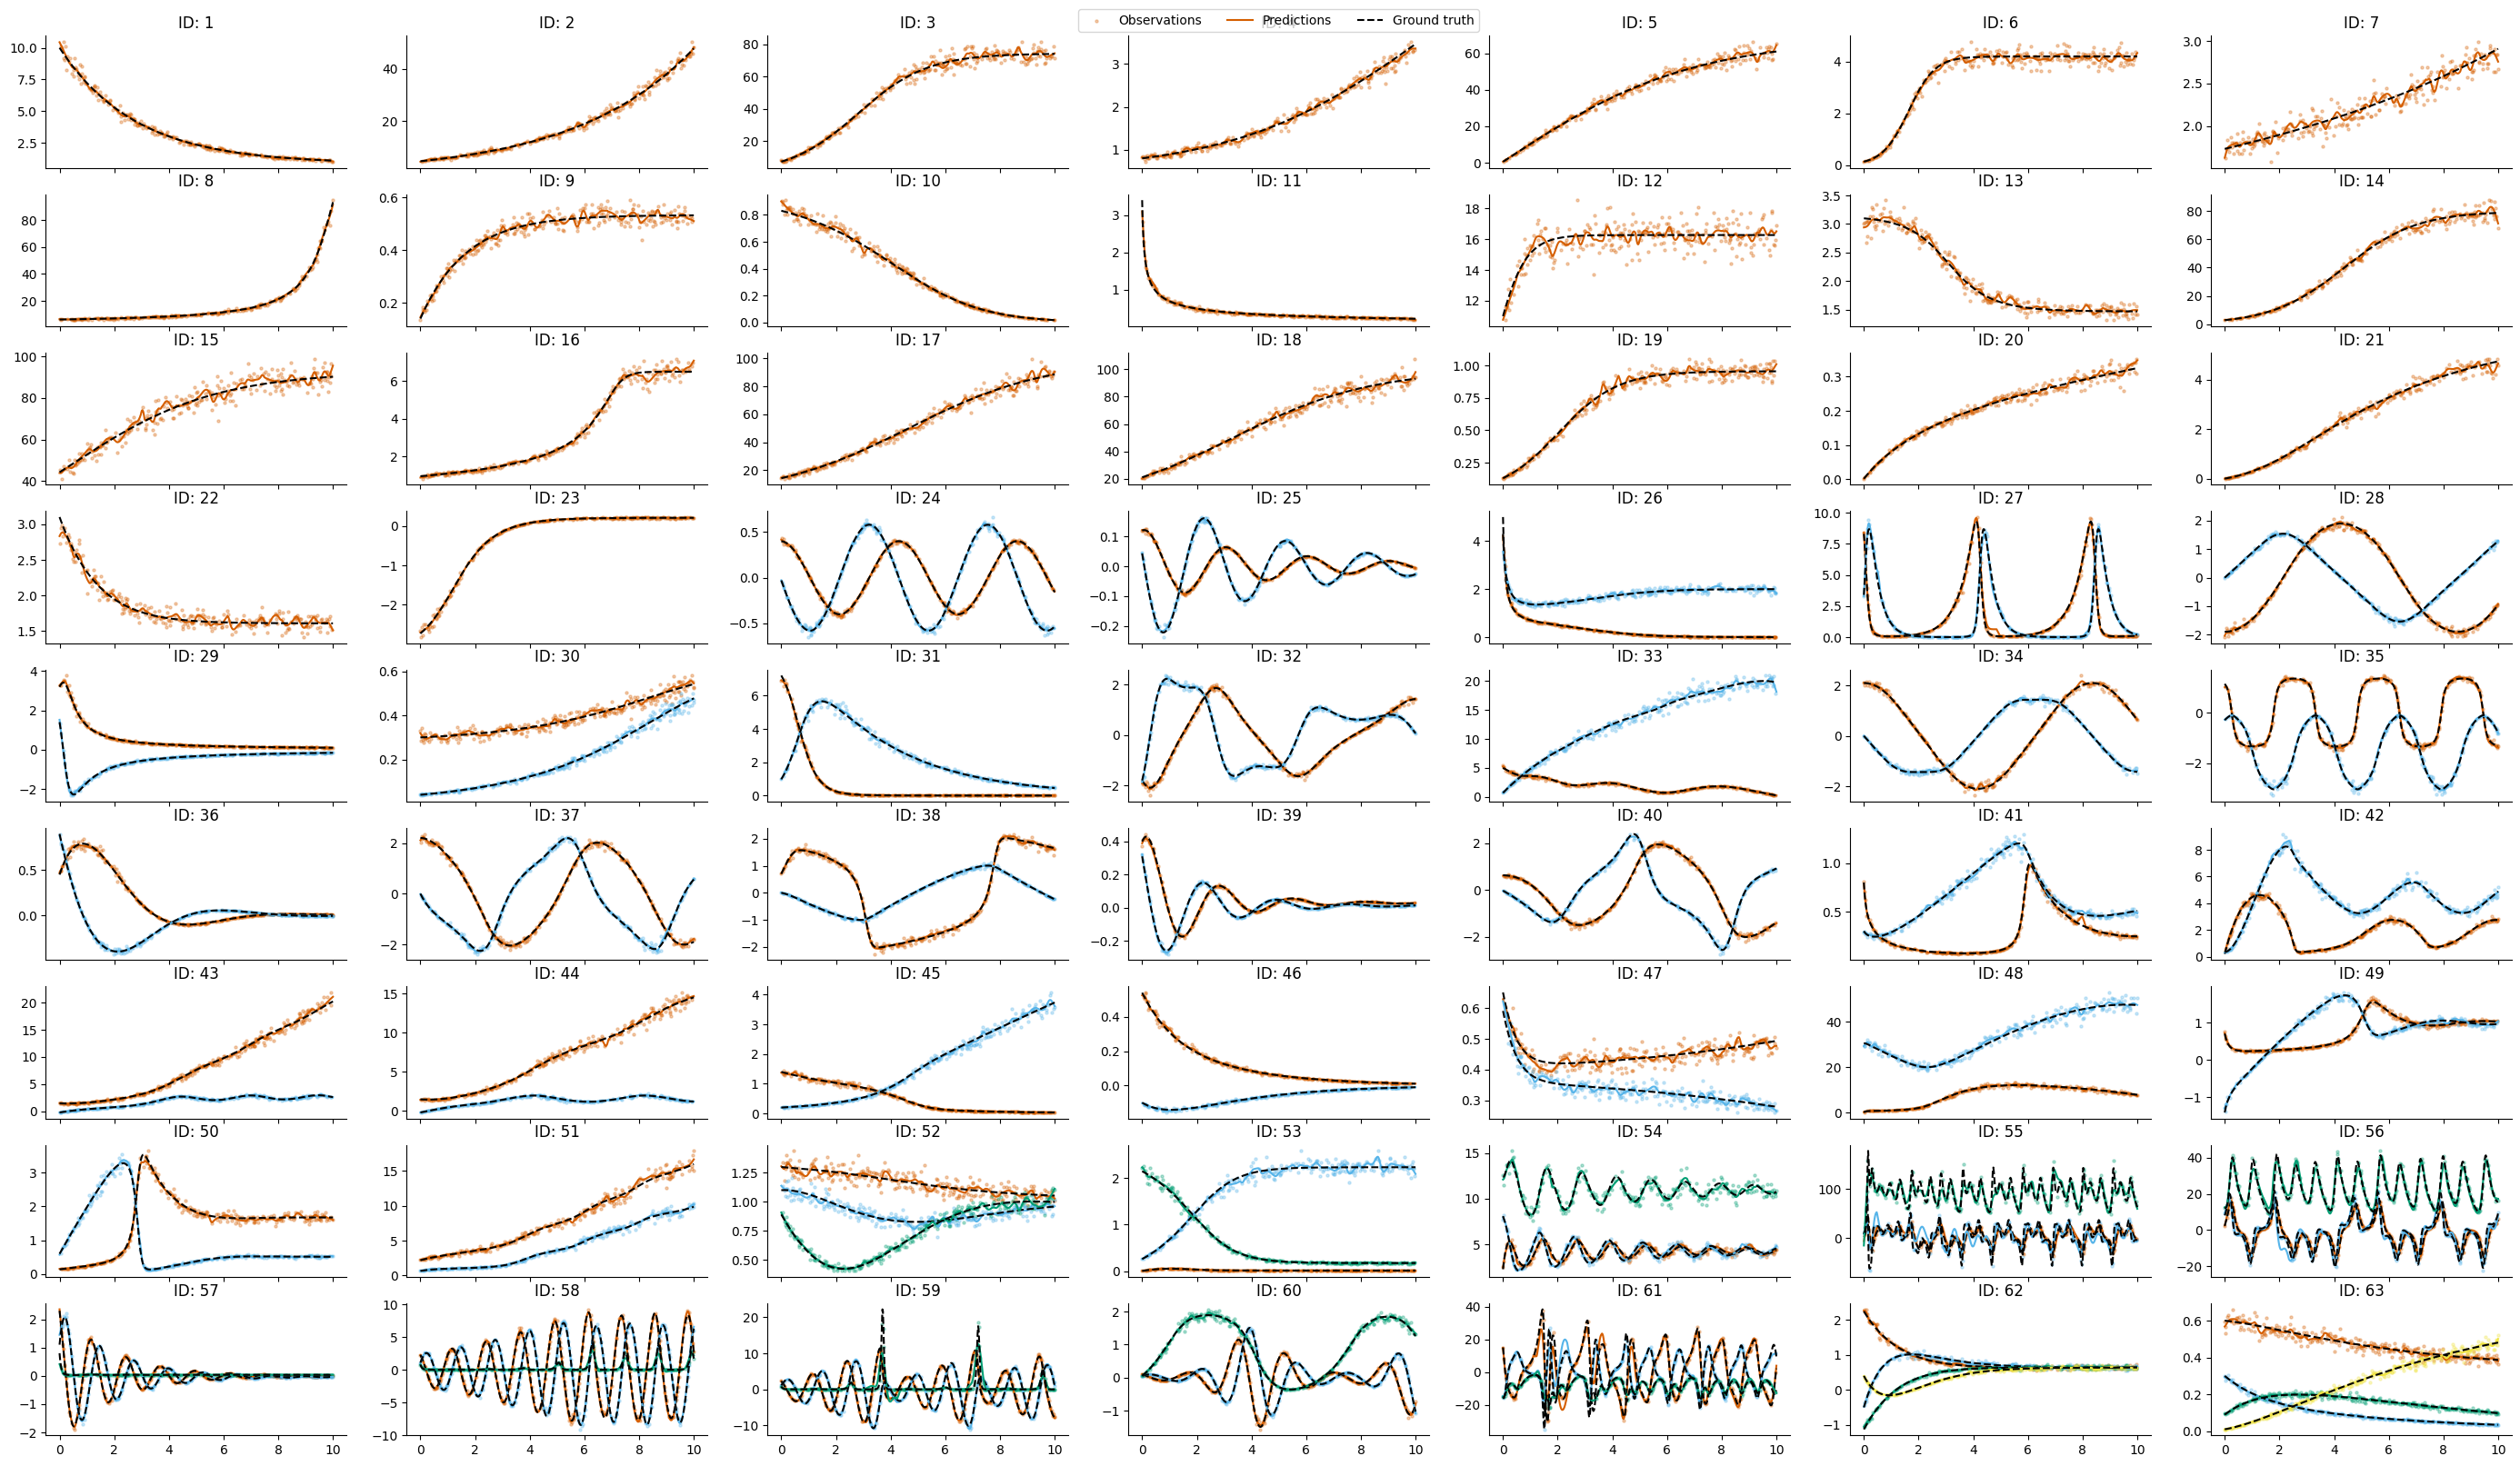

In [18]:
# Define a function to handle plotting
def plot_data(axes, data, id_range, num_dims):
    for id in id_range:
        index = (data['ids'] == id).nonzero(as_tuple=True)[0][0].item()
        obs_mask = data['observation_mask'][index]
        obs_values = data['observation_values'][index][~obs_mask.squeeze(-1)]
        obs_times = data['observation_times'][index][~obs_mask]
        times = data['times_target'][index]
        pred_values = data['sample_path_prediction'][index]
        ground_truth = data['sample_paths_target'][index]

        for dim in range(num_dims):
            axes[id-1].scatter(obs_times, obs_values[:, dim], color=colors[dim], s=5, alpha=0.3, label='Observations')
            axes[id-1].plot(times, pred_values[:, dim], color=colors[dim], label='Predictions')
            axes[id-1].plot(times, ground_truth[:, dim], color="black", linestyle="--", label='Ground truth')
        axes[id-1].set_title(f"ID: {id}")

# Plotting
fig, axes = plt.subplots(ncols=7, nrows=9, figsize=(35, 20), sharex=True)
axes = axes.flatten()

# colors = ['r', 'b', 'orange', 'purple']
# colors = ['#0072B2', '#E69F00', '#009E73', '#CC79A7']
colors = ['#D55E00', '#56B4E9', '#009E73', '#F0E442']

# Plot for each dimension
plot_data(axes, data_dim_1, range(1, 24), num_dims=1)
plot_data(axes, data_dim_2, range(24, 52), num_dims=2)
plot_data(axes, data_dim_3, range(52, 62), num_dims=3)
plot_data(axes, data_dim_4, range(62, 64), num_dims=4)

# Finalize the plot
axes[3].legend(loc='upper center', bbox_to_anchor=(0.5, 1.25), ncol=3)
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()

# Display metrics


### compute metrics averaged over dimensions

In [19]:

dims = [1, 2, 3, 4]
rhos =["0_0", "0_5"]
sigmas = ["0.0", "0.05"]
models = ['MinMax', 'RevIN']
metric = "r2_score_above0.9"
window_counts = [8,12,16, 20]

# average over dimension types
print("Average over dimension types, metric ", metric)
for wc in window_counts:
    print(f"{wc} windows, 25% overlap")
    for model in models:
        data_folder = f"reports/FIMWindowed/ODEBench/{wc}windows_25%overlap/{model}/"
        print(f"\tModel: {model}")
        for sigma in sigmas:
            for rho in rhos:
                metrics = []
                for dim in dims:
                    with open(data_folder + f"dim{dim}" + "_sigma" + sigma + "_rho" + rho + "/metrics.json", "r") as f:
                        data_per_dim = json.load(f)
                    metrics.append(data_per_dim[metric])

                print(f"\t\t sigma={sigma} and rho={rho}: {sum(metrics) / len(metrics):.4} +/- {torch.std(torch.tensor(metrics)).item():.4}")


Average over dimension types, metric  r2_score_above0.9
8 windows, 25% overlap
	Model: MinMax
		 sigma=0.0 and rho=0_0: 0.8286 +/- 0.3195
		 sigma=0.0 and rho=0_5: 0.8343 +/- 0.3229
		 sigma=0.05 and rho=0_0: 0.8089 +/- 0.3298
		 sigma=0.05 and rho=0_5: 0.802 +/- 0.3388
	Model: RevIN
		 sigma=0.0 and rho=0_0: 0.8187 +/- 0.3132
		 sigma=0.0 and rho=0_5: 0.8288 +/- 0.3195
		 sigma=0.05 and rho=0_0: 0.8032 +/- 0.3231
		 sigma=0.05 and rho=0_5: 0.8041 +/- 0.3367
12 windows, 25% overlap
	Model: MinMax
		 sigma=0.0 and rho=0_0: 0.8875 +/- 0.225
		 sigma=0.0 and rho=0_5: 0.8975 +/- 0.205
		 sigma=0.05 and rho=0_0: 0.8608 +/- 0.238
		 sigma=0.05 and rho=0_5: 0.8673 +/- 0.2132
	Model: RevIN
		 sigma=0.0 and rho=0_0: 0.875 +/- 0.25
		 sigma=0.0 and rho=0_5: 0.885 +/- 0.23
		 sigma=0.05 and rho=0_0: 0.8531 +/- 0.2594
		 sigma=0.05 and rho=0_5: 0.8481 +/- 0.2501
16 windows, 25% overlap
	Model: MinMax
		 sigma=0.0 and rho=0_0: 0.95 +/- 0.1
		 sigma=0.0 and rho=0_5: 0.9513 +/- 0.0975
		 sigma=0.05 a

### mean / std of a metric per dim

In [2]:
import json
import torch
import pandas as pd
from itertools import product

# Variables
dims = [1, 2, 3, 4]
rhos = ["0_0", "0_5"]
sigmas = ["0.0", "0.05"]
models = [
    'MinMax', 
    'MinMax_SavGol',
    'RevIN', 
    'RevIN_SavGol' ]
metric = "r2_score_above0.9"
window_counts = [8, 12, 16, 20]

print("Average over dimension types, metric ", metric)
print("25% overlap")

# Create a MultiIndex DataFrame
index = pd.MultiIndex.from_product([window_counts, models], names=["Window Count", "Model"])
columns = [f"sigma={sigma}_rho={rho}" for sigma in sigmas for rho in rhos]
df = pd.DataFrame(index=index, columns=columns)

# Load the data and calculate the mean and standard deviation for each combination
for wc, model, sigma, rho in product(window_counts, models, sigmas, rhos):
    metrics = []
    for dim in dims:
        file_path = f"reports/FIMWindowed/ODEBench/{wc}windows_25%overlap/{model}/dim{dim}" + "_sigma" + sigma + "_rho" + rho + "/metrics.json"
        with open(file_path, "r") as f:
            data_json = json.load(f)
        metrics.append(data_json[metric])

    mean_metric = sum(metrics) / len(metrics)
    std_metric = torch.std(torch.tensor(metrics)).item()

    df.loc[(wc, model), f"sigma={sigma}_rho={rho}"] = f"{mean_metric:.2f} +/- {std_metric:.2f}"

# Display the DataFrame
df

Average over dimension types, metric  r2_score_above0.9
25% overlap


sigma=0.0_rho=0_0 sigma=0.0_rho=0_5  \
Window Count Model                                               
8            MinMax            0.83 +/- 0.32     0.83 +/- 0.32   
             MinMax_SavGol     0.83 +/- 0.32     0.84 +/- 0.32   
             RevIN             0.82 +/- 0.31     0.83 +/- 0.32   
             RevIN_SavGol      0.82 +/- 0.31     0.83 +/- 0.32   
12           MinMax            0.89 +/- 0.22     0.90 +/- 0.21   
             MinMax_SavGol     0.89 +/- 0.22     0.87 +/- 0.26   
             RevIN             0.88 +/- 0.25     0.89 +/- 0.23   
             RevIN_SavGol      0.89 +/- 0.22     0.87 +/- 0.27   
16           MinMax            0.95 +/- 0.10     0.95 +/- 0.10   
             MinMax_SavGol     0.96 +/- 0.07     0.91 +/- 0.19   
             RevIN             0.95 +/- 0.10     0.95 +/- 0.10   
             RevIN_SavGol      0.95 +/- 0.10     0.91 +/- 0.18   
20           MinMax            0.96 +/- 0.07     0.96 +/- 0.08   
             MinMax_SavGol     0.97 +/- 0.05     0.92 +/- 0.16   
             RevIN             0.96 +/- 0.07     0.96 +/- 0.08   
             RevIN_SavGol      0.96 +/- 0.07     0.92 +/- 0.17   

                           sigma=0.05_rho=0_0 sigma=0.05_rho=0_5  
Window Count Model                                                
8            MinMax             0.81 +/- 0.33      0.80 +/- 0.34  
             MinMax_SavGol      0.80 +/- 0.33      0.81 +/- 0.34  
             RevIN              0.80 +/- 0.32      0.80 +/- 0.34  
             RevIN_SavGol       0.80 +/- 0.33      0.80 +/- 0.34  
12           MinMax             0.86 +/- 0.24      0.87 +/- 0.21  
             MinMax_SavGol      0.86 +/- 0.24      0.84 +/- 0.27  
             RevIN              0.85 +/- 0.26      0.85 +/- 0.25  
             RevIN_SavGol       0.85 +/- 0.25      0.84 +/- 0.28  
16           MinMax             0.92 +/- 0.12      0.92 +/- 0.11  
             MinMax_SavGol      0.93 +/- 0.11      0.87 +/- 0.20  
             RevIN              0.92 +/- 0.11      0.91 +/- 0.12  
             RevIN_SavGol       0.92 +/- 0.11      0.87 +/- 0.20  
20           MinMax             0.93 +/- 0.09      0.92 +/- 0.10  
             MinMax_SavGol      0.94 +/- 0.08      0.88 +/- 0.18  
             RevIN              0.93 +/- 0.09      0.92 +/- 0.10  
             RevIN_SavGol       0.93 +/- 0.09      0.88 +/- 0.18

### Split by dimensions

In [3]:
import json
import torch
from itertools import product
import pandas as pd

# Variables
dims = [1, 2, 3, 4]
rhos = ["0_0", "0_5"]
sigmas = ["0.0", "0.05"]
models = [
    'MinMax', 
    'MinMax_SavGol',
    'RevIN', 
    'RevIN_SavGol' ]
metric = "r2_score_above0.9"
# window_counts = [8, 12, 16, 20]

window_count = 8

print("Average per dimension type, metric ", metric)
print(f"25% overlap, {window_count} windows")

# Create a MultiIndex DataFrame
index = pd.MultiIndex.from_product([models, dims], names=["model", "dim"])
columns = [f"sigma={sigma}_rho={rho}" for sigma in sigmas for rho in rhos]
df = pd.DataFrame(index=index, columns=columns)

for model, dim, sigma, rho in product(models, dims, sigmas, rhos):
    file_path = f"reports/FIMWindowed/ODEBench/{window_count}windows_25%overlap/{model}/dim{dim}_sigma{sigma}_rho{rho}/metrics.json"
    with open(file_path, "r") as f:
        metrics = json.load(f)
    df.loc[(model, dim), f"sigma={sigma}_rho={rho}"] = f"{metrics[metric]:.2f}"

# Display the DataFrame
df

Average per dimension type, metric  r2_score_above0.9
25% overlap, 8 windows


sigma=0.0_rho=0_0 sigma=0.0_rho=0_5 sigma=0.05_rho=0_0  \
model         dim                                                          
MinMax        1                1.00              1.00               0.95   
              2                0.96              0.99               0.97   
              3                0.35              0.35               0.32   
              4                1.00              1.00               1.00   
MinMax_SavGol 1                1.00              1.00               0.95   
              2                0.96              0.99               0.95   
              3                0.35              0.35               0.30   
              4                1.00              1.00               1.00   
RevIN         1                0.98              1.00               0.95   
              2                0.95              0.97               0.94   
              3                0.35              0.35               0.32   
              4                1.00              1.00               1.00   
RevIN_SavGol  1                0.98              1.00               0.94   
              2                0.95              0.98               0.93   
              3                0.35              0.34               0.31   
              4                1.00              1.00               1.00   

                  sigma=0.05_rho=0_5  
model         dim                     
MinMax        1                 0.94  
              2                 0.97  
              3                 0.29  
              4                 1.00  
MinMax_SavGol 1                 0.95  
              2                 0.97  
              3                 0.29  
              4                 1.00  
RevIN         1                 0.95  
              2                 0.96  
              3                 0.30  
              4                 1.00  
RevIN_SavGol  1                 0.95  
              2                 0.96  
              3                 0.29  
              4                 1.00